# GNN Explanation:
The explanation in this notebook is based on the GNN example from the [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)

In [18]:
!python --version
!python -c "import torch; print(torch.has_mps)"
!python -c "import torch; print(torch.__version__)"

Python 3.11.2
True
2.0.1


In [19]:
CUDA="cpu"
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+$\{CUDA\}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+$\{CUDA\}.html
!pip install torch-cluster
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+${CUDA}.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+${CUDA}.html


In [20]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
from torch_geometric.datasets import KarateClub
dataset=KarateClub()
data=dataset[0]
print(data)
print(data.train_mask)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


### Training mask / GNN objective:
Among the 34 members (or nodes) all are False except 4 (these four are labeled). But the rest 30 have no labels, and *they can be trained to asssign labels, with the help of pre-assigned 4 labels*.

In [22]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, dataset.num_classes)
        self.conv2 = GCNConv(dataset.num_classes, dataset.num_classes)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [23]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
h

Embedding shape: [34, 2]


tensor([[ 0.0962,  0.0115],
        [ 0.0235,  0.0129],
        [ 0.0432,  0.0201],
        [ 0.0401,  0.0162],
        [ 0.0522, -0.0054],
        [ 0.0775,  0.0011],
        [ 0.0763,  0.0031],
        [ 0.0300,  0.0131],
        [ 0.0107,  0.0181],
        [ 0.0014,  0.0195],
        [ 0.0575, -0.0035],
        [ 0.0867,  0.0090],
        [ 0.0353,  0.0106],
        [ 0.0242,  0.0179],
        [-0.0114,  0.0138],
        [-0.0109,  0.0173],
        [ 0.0740,  0.0046],
        [ 0.0188,  0.0012],
        [-0.0139,  0.0210],
        [ 0.0068,  0.0108],
        [ 0.0077,  0.0168],
        [ 0.0014,  0.0033],
        [-0.0065,  0.0175],
        [ 0.0657,  0.0242],
        [ 0.1390,  0.0069],
        [ 0.1296,  0.0110],
        [-0.0140,  0.0309],
        [ 0.0852,  0.0189],
        [ 0.0415,  0.0141],
        [ 0.0032,  0.0333],
        [-0.0036,  0.0152],
        [ 0.0995,  0.0135],
        [ 0.0102,  0.0337],
        [ 0.0181,  0.0381]], grad_fn=<TanhBackward0>)

In [24]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(12,8))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

from sklearn.manifold import TSNE

def visualize_tsne(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

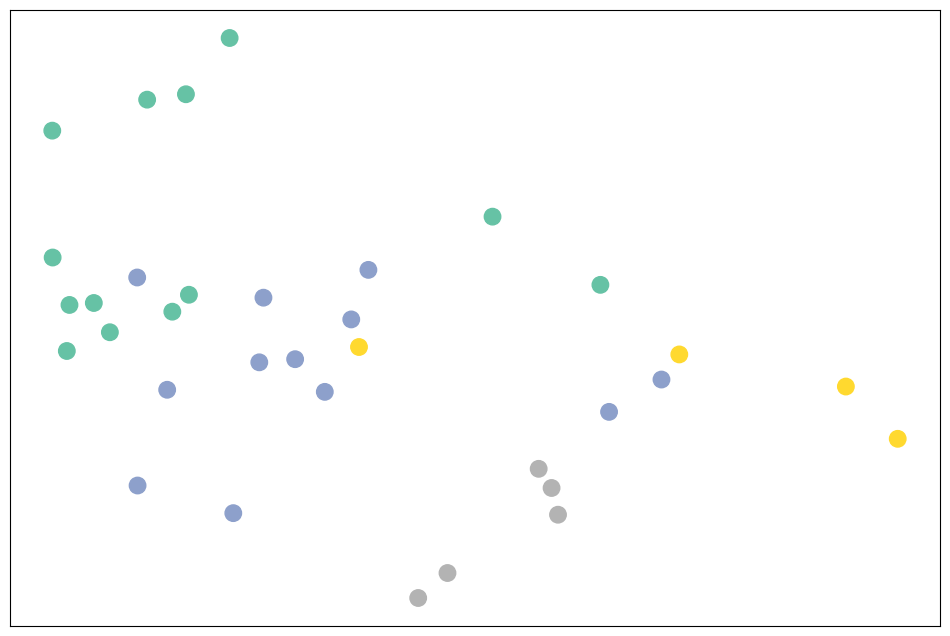

In [25]:
visualize_embedding(h, color=data.y)

#### Note: 
 - 4 classes are visible
 - Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random
 - this is just due to embedding, before any training.


## Model training:

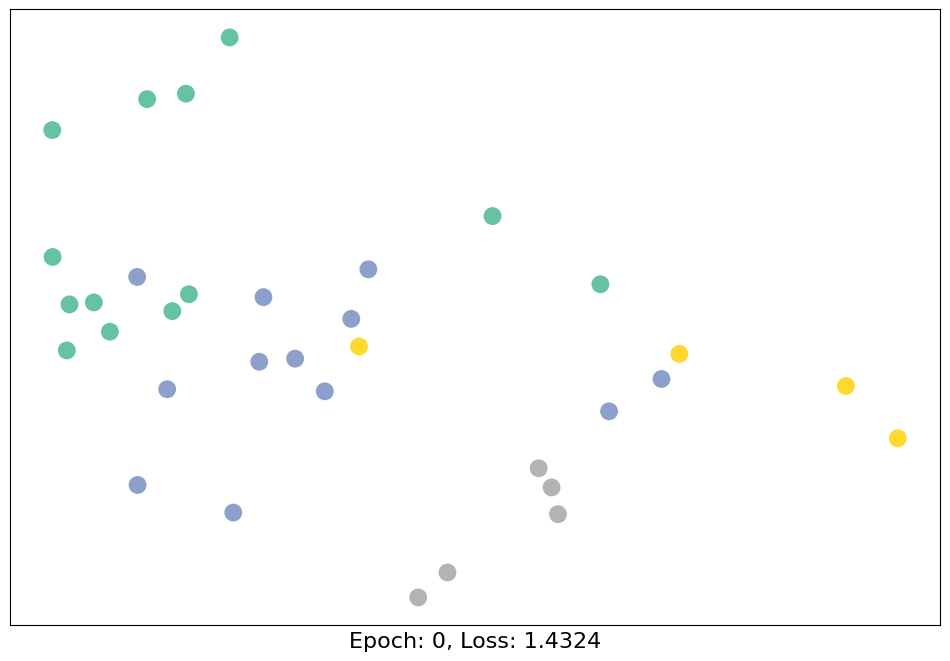

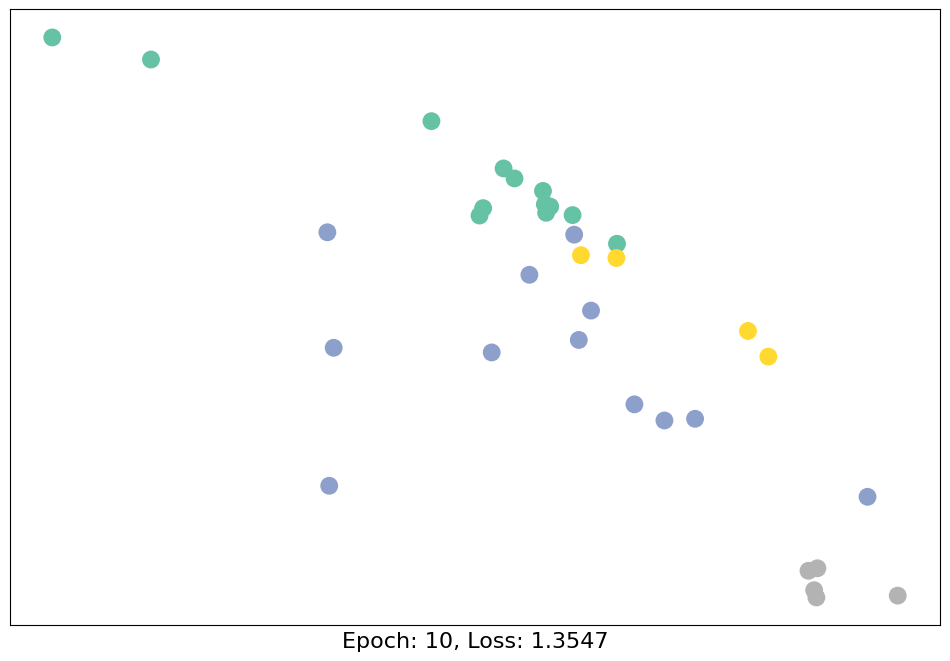

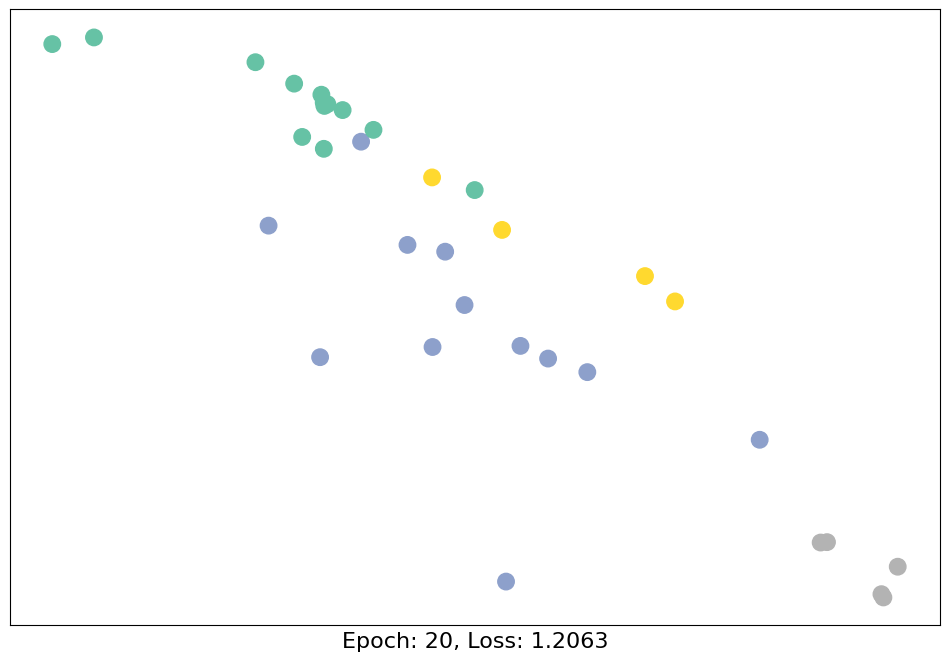

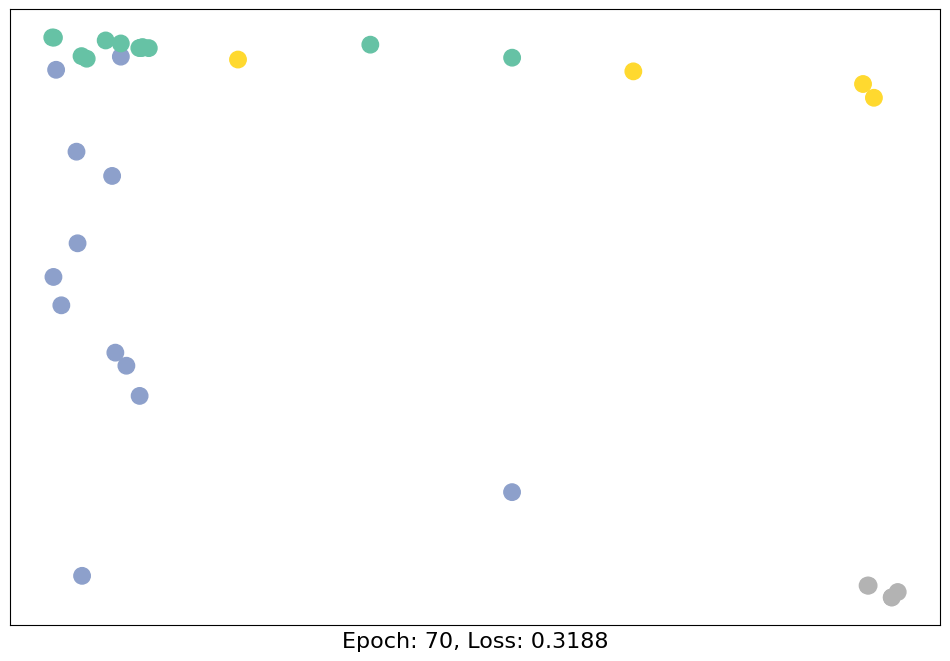

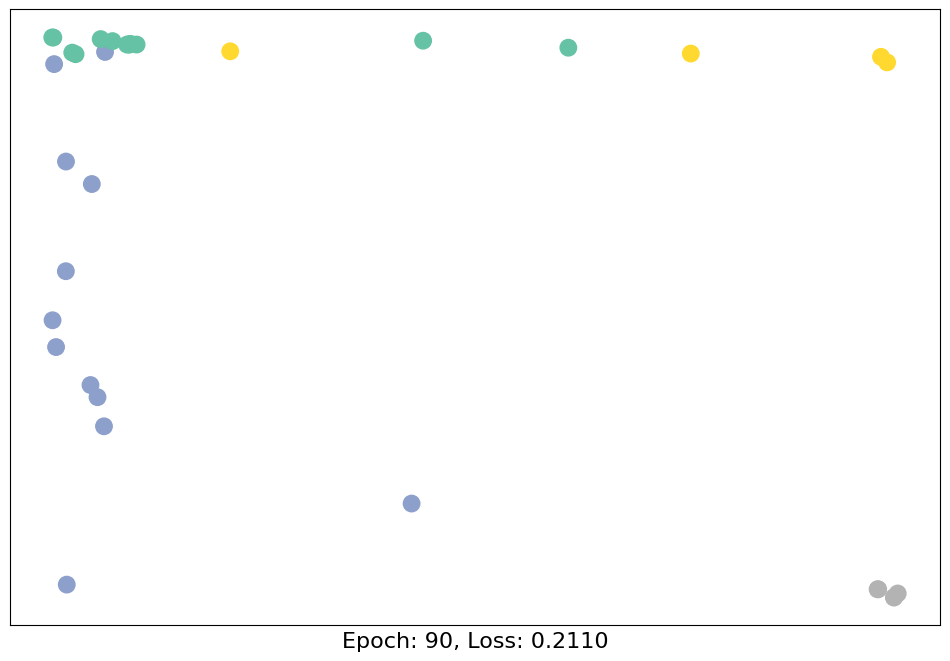

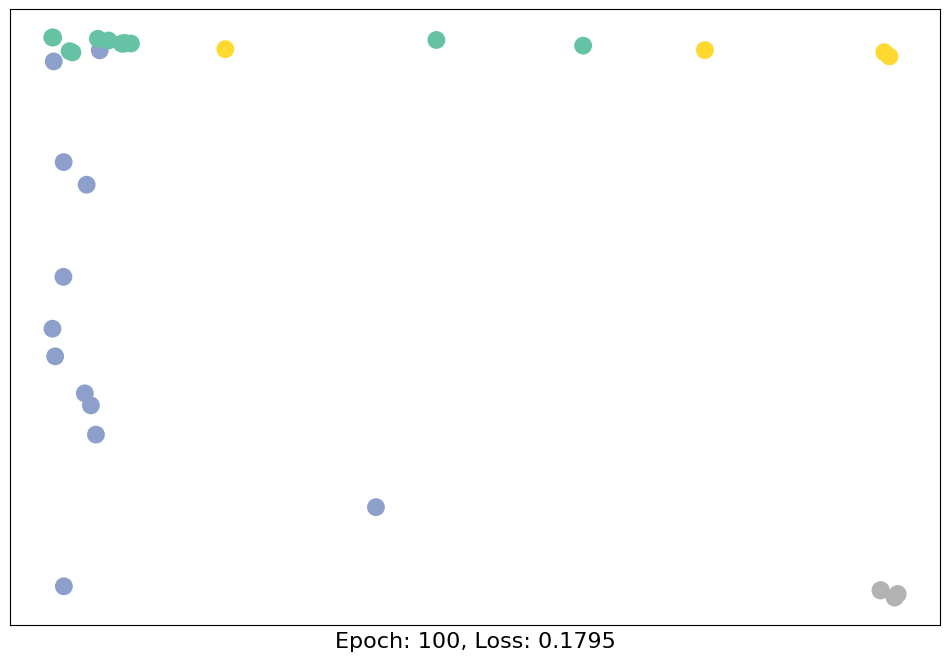

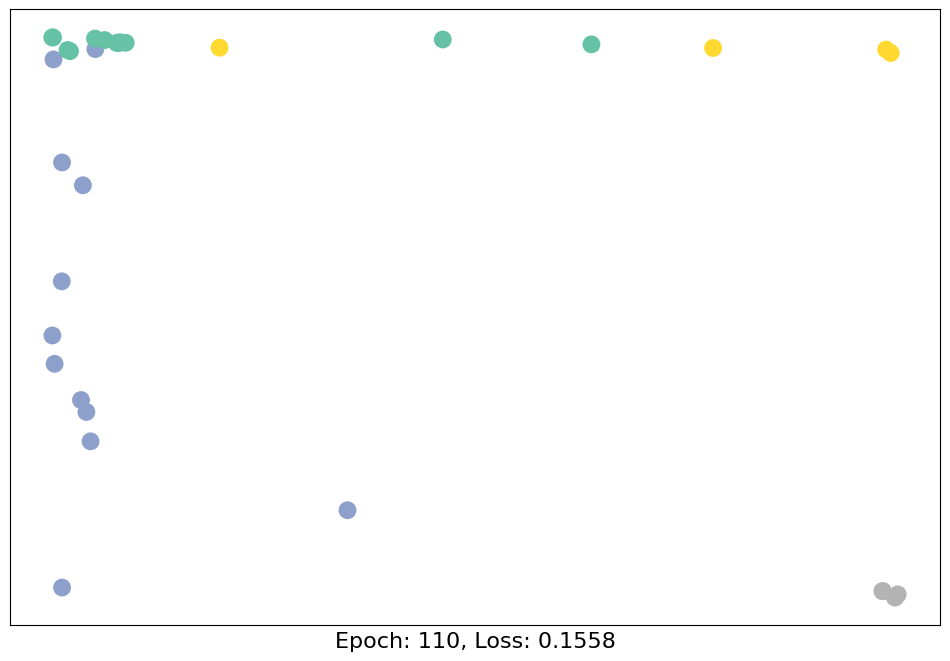

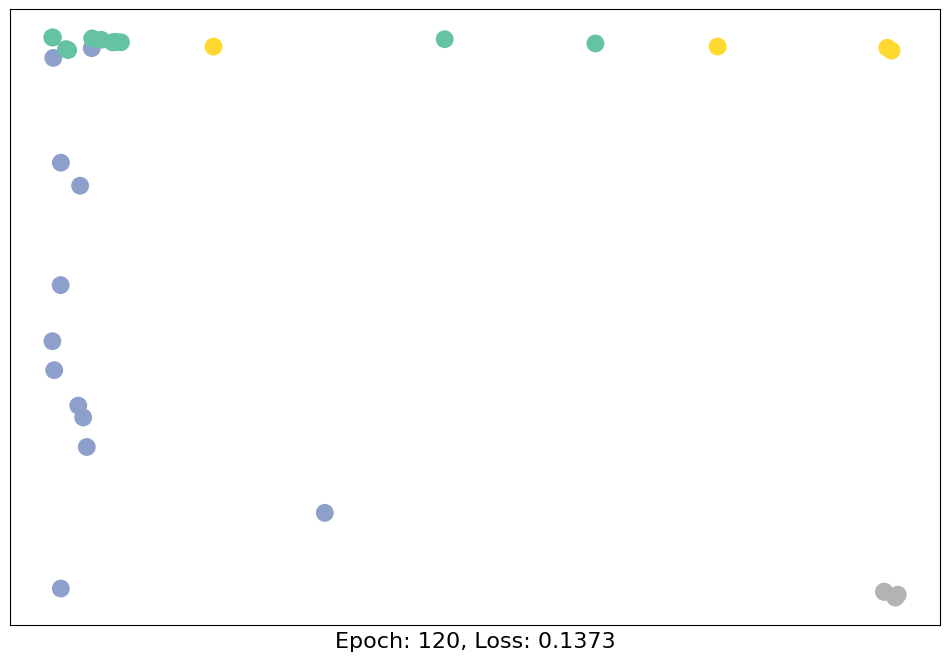

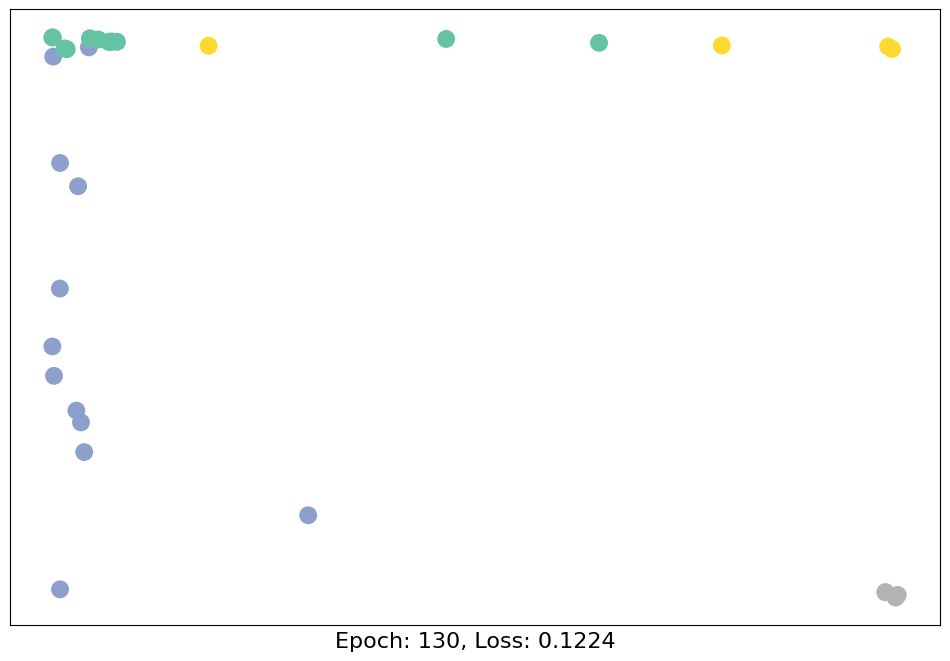

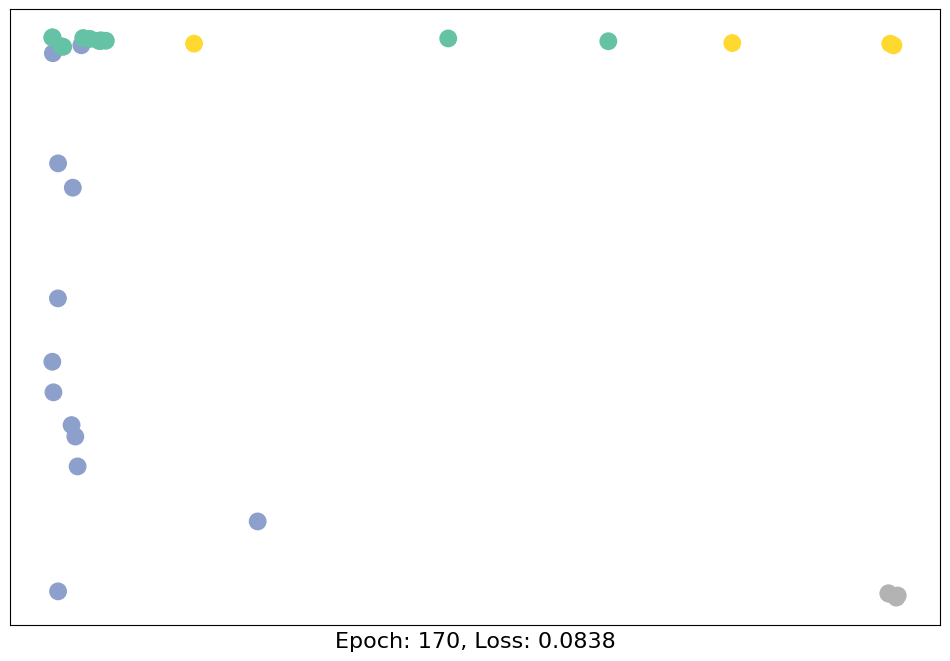

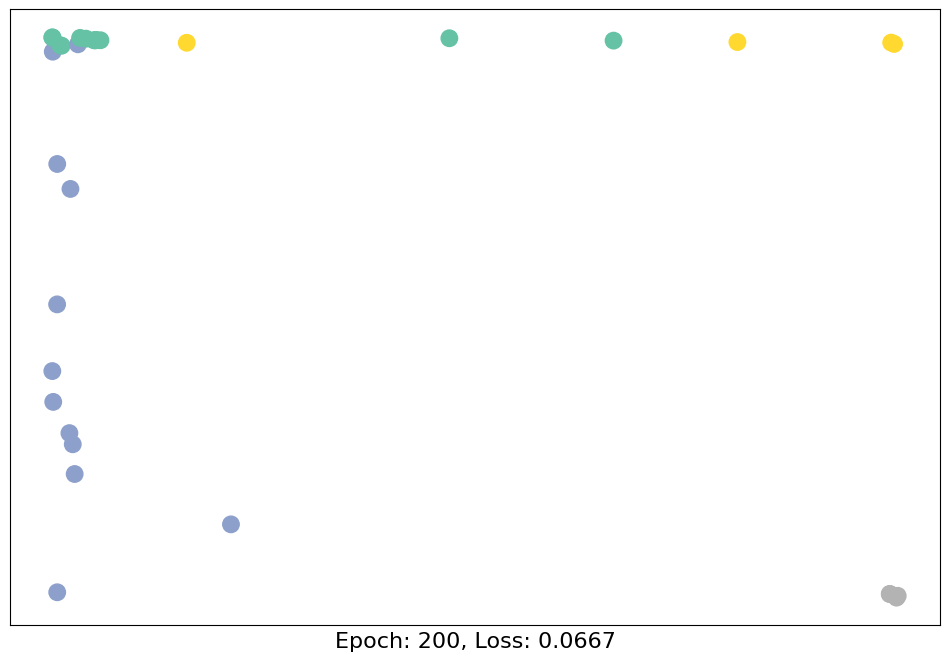

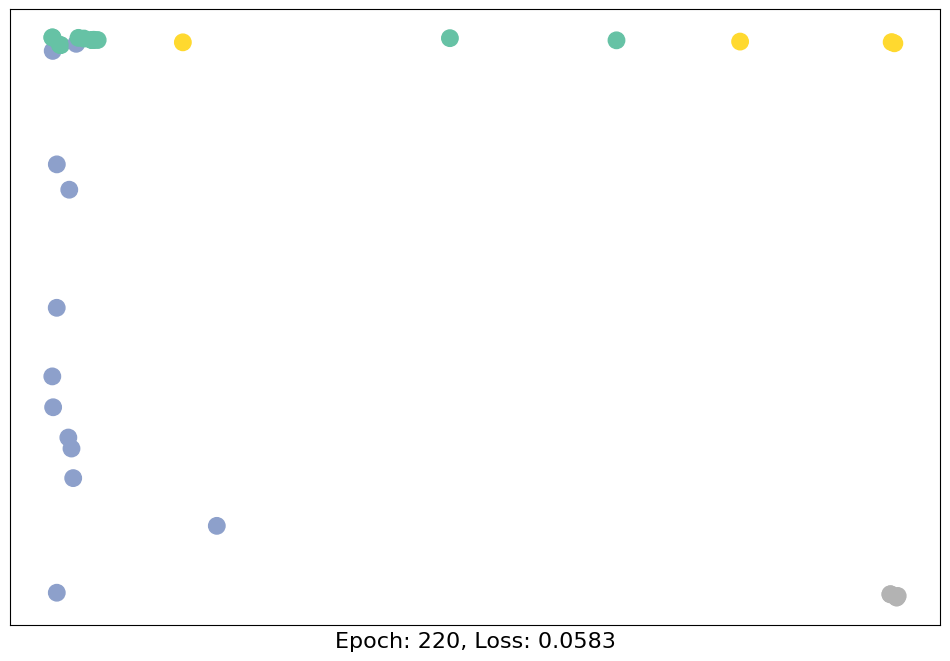

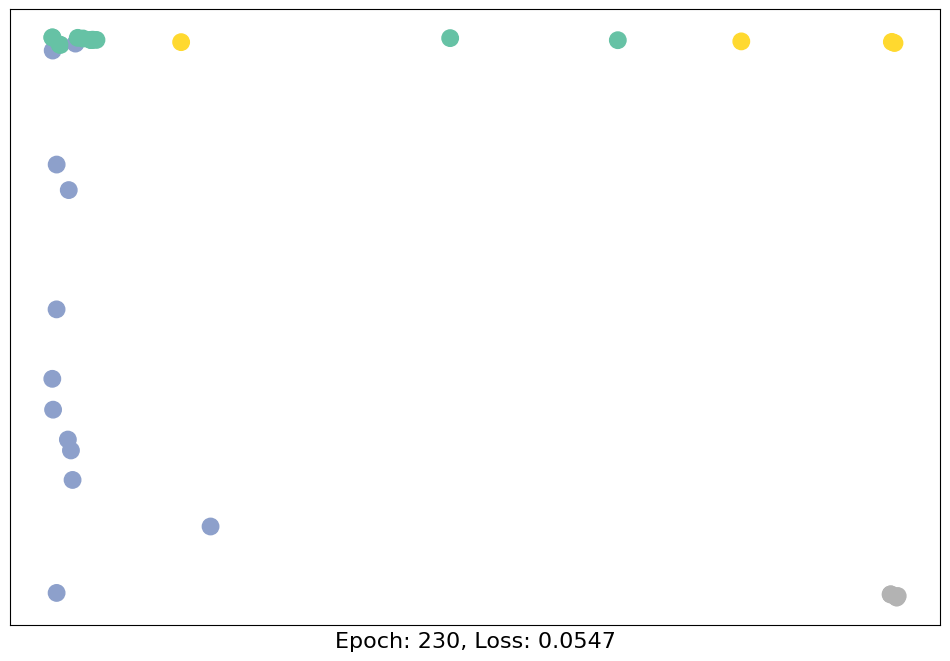

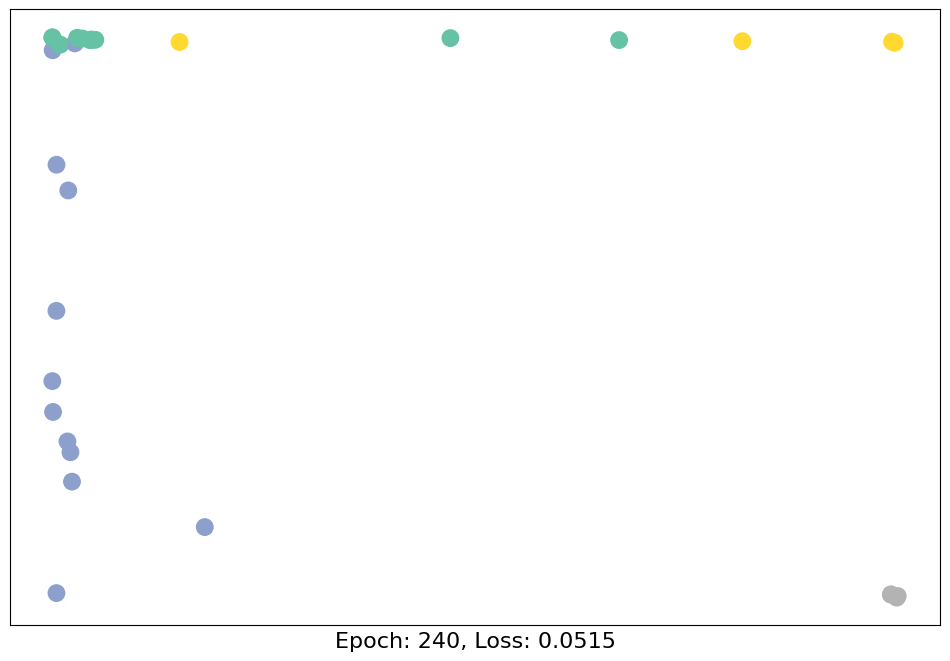

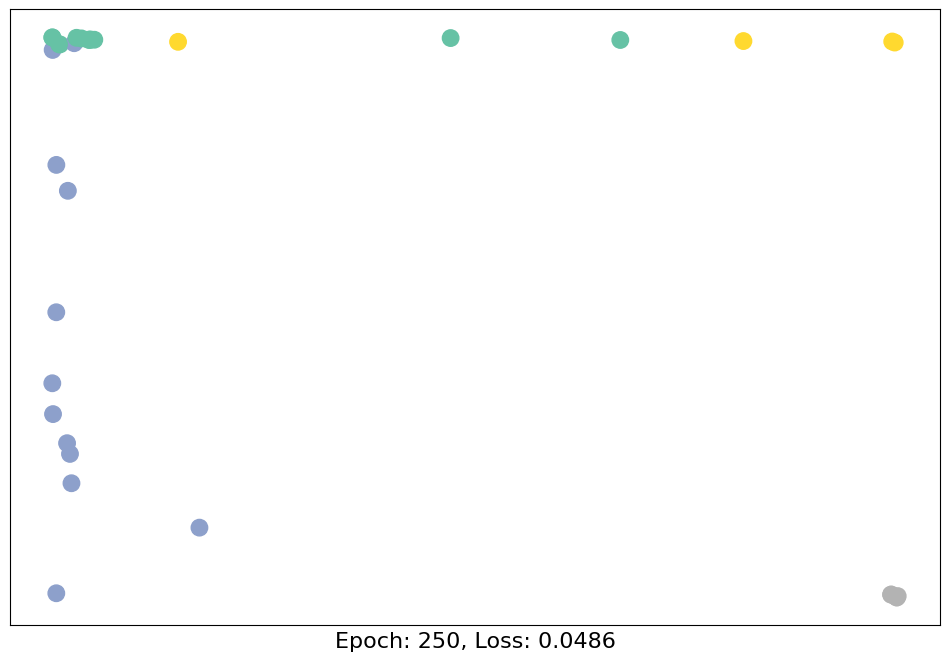

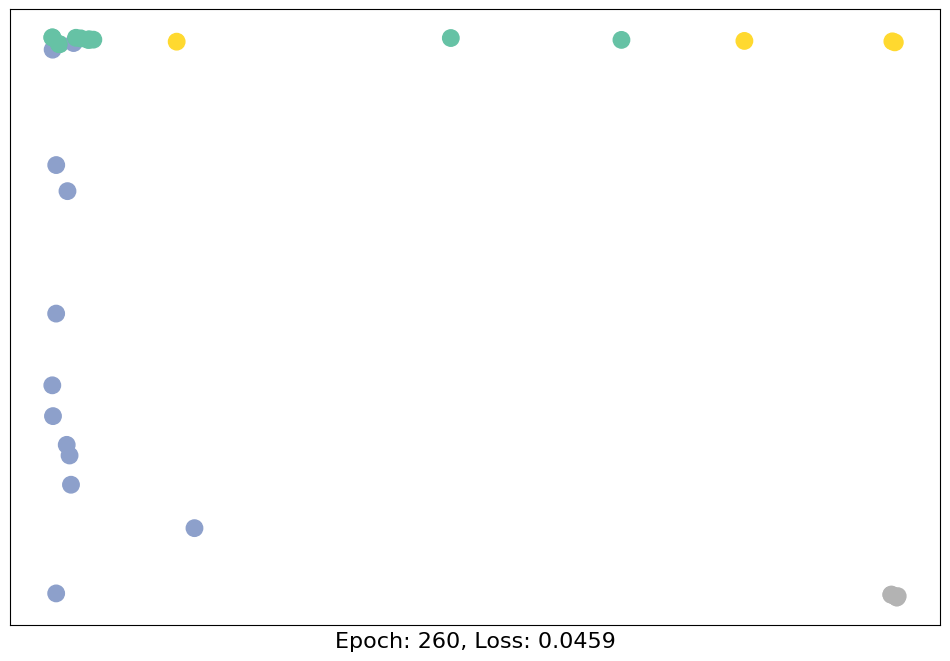

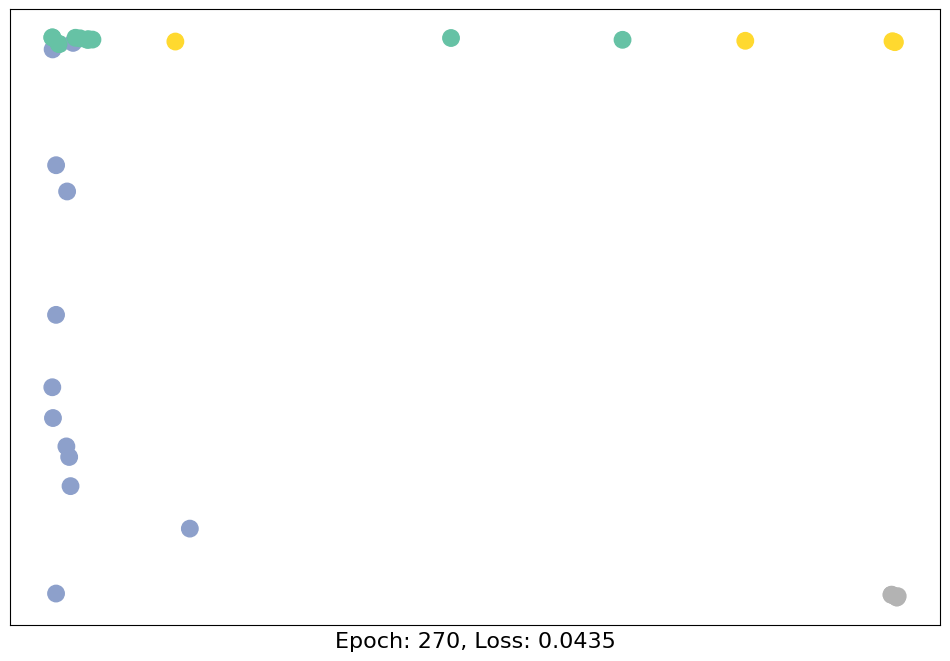

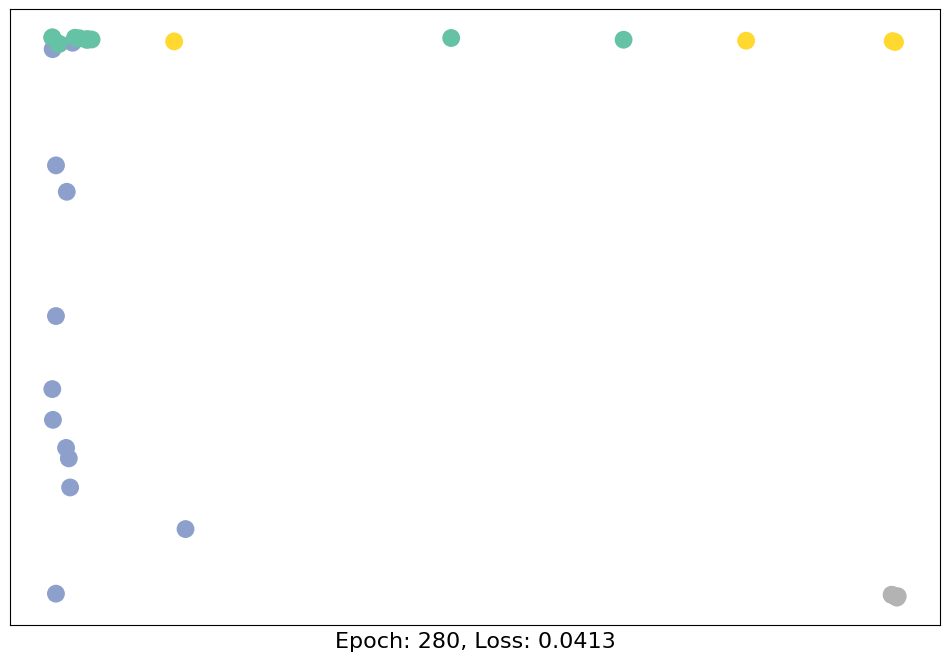

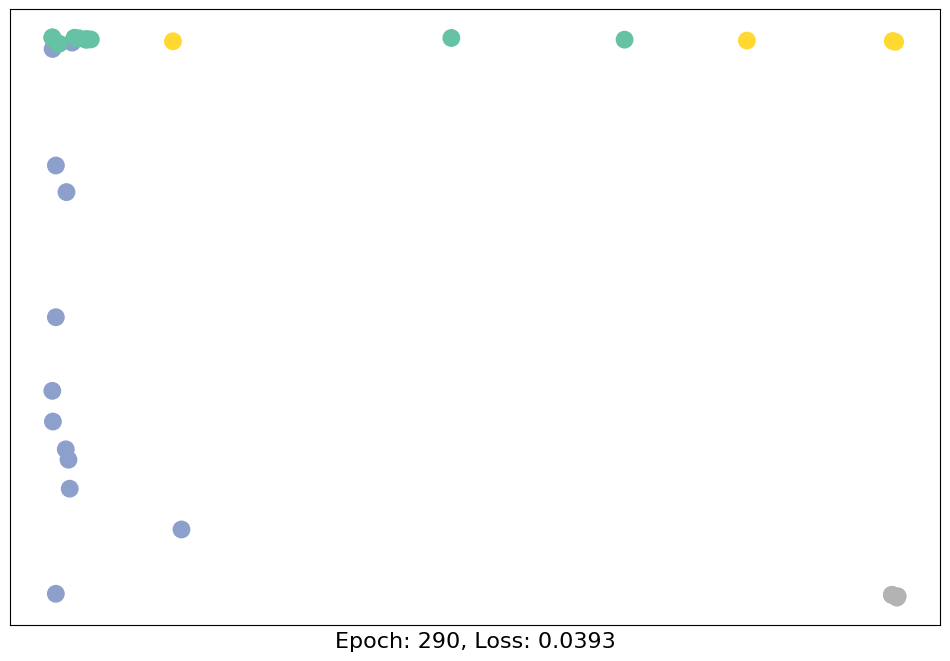

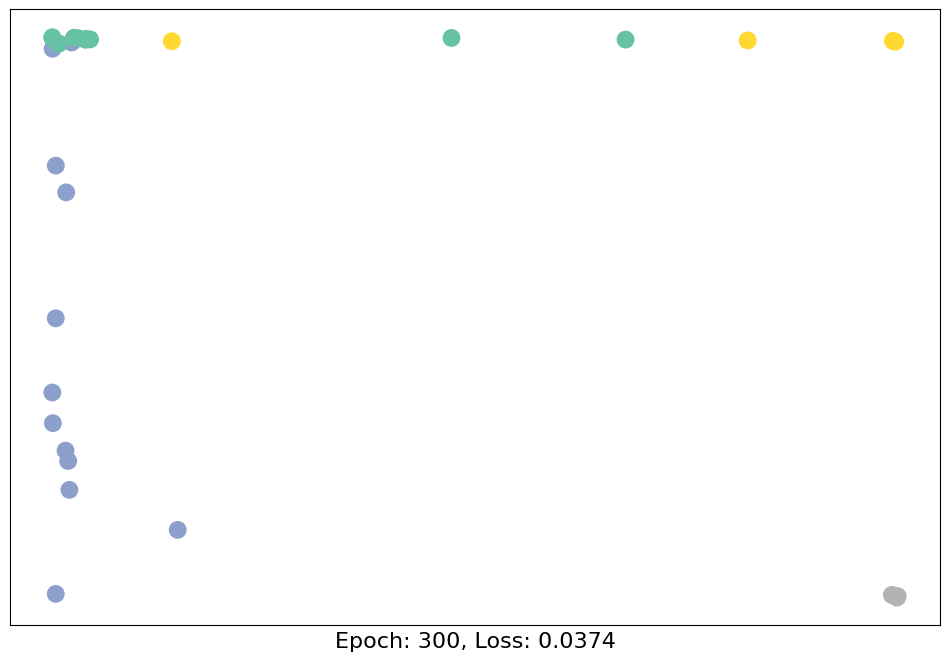

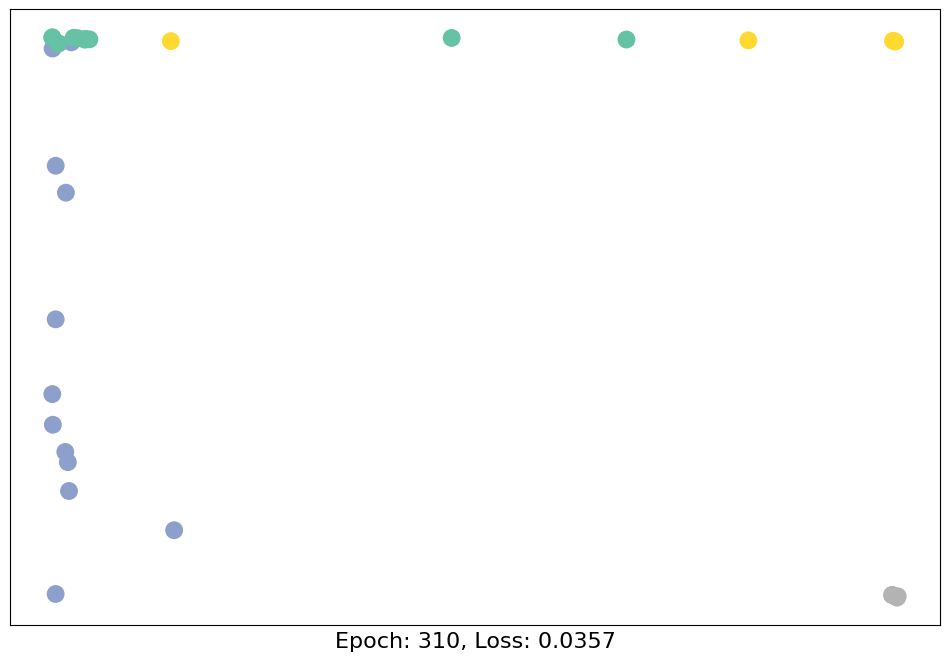

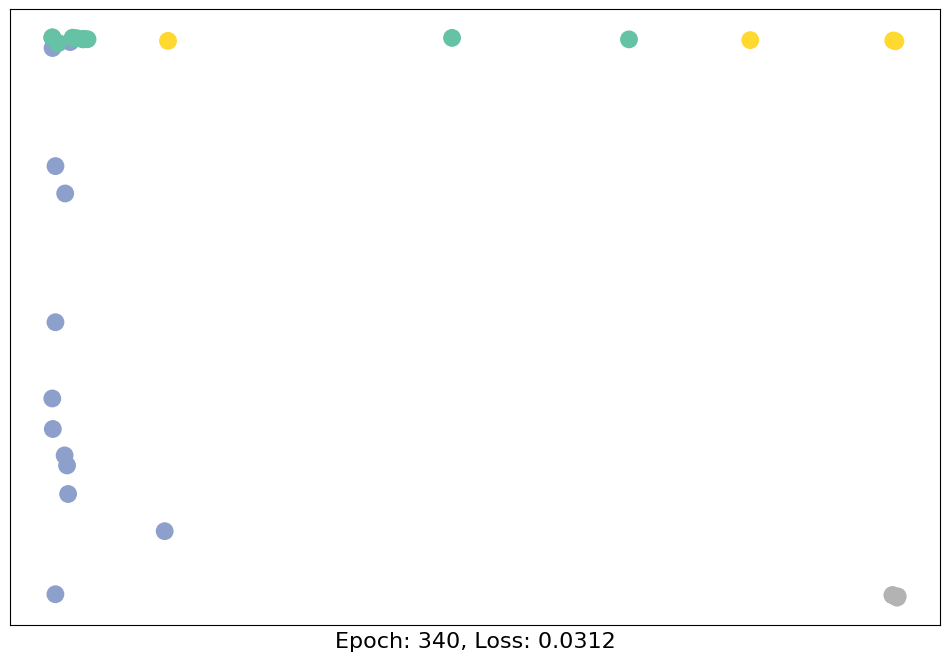

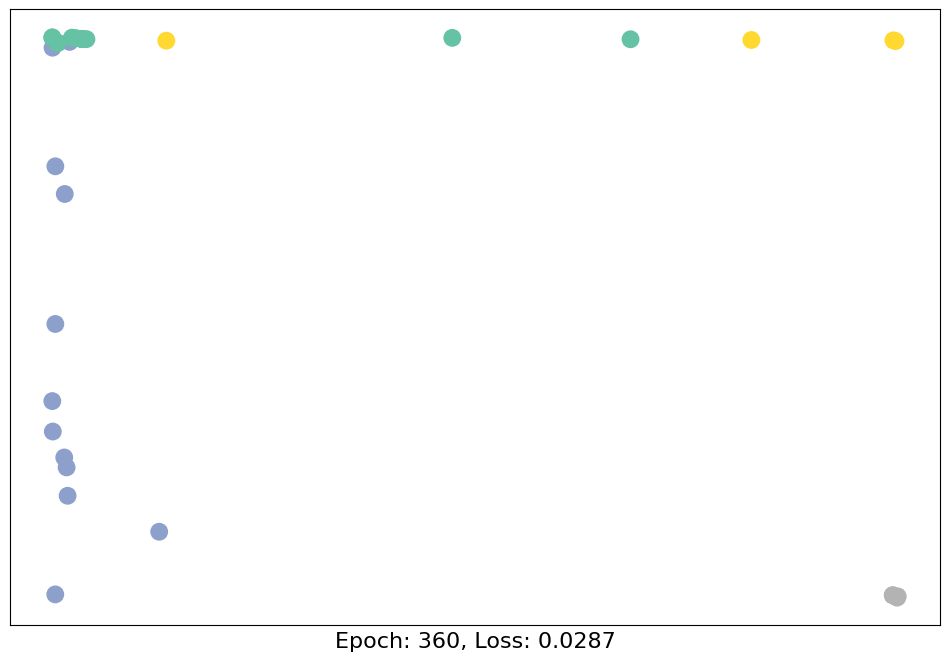

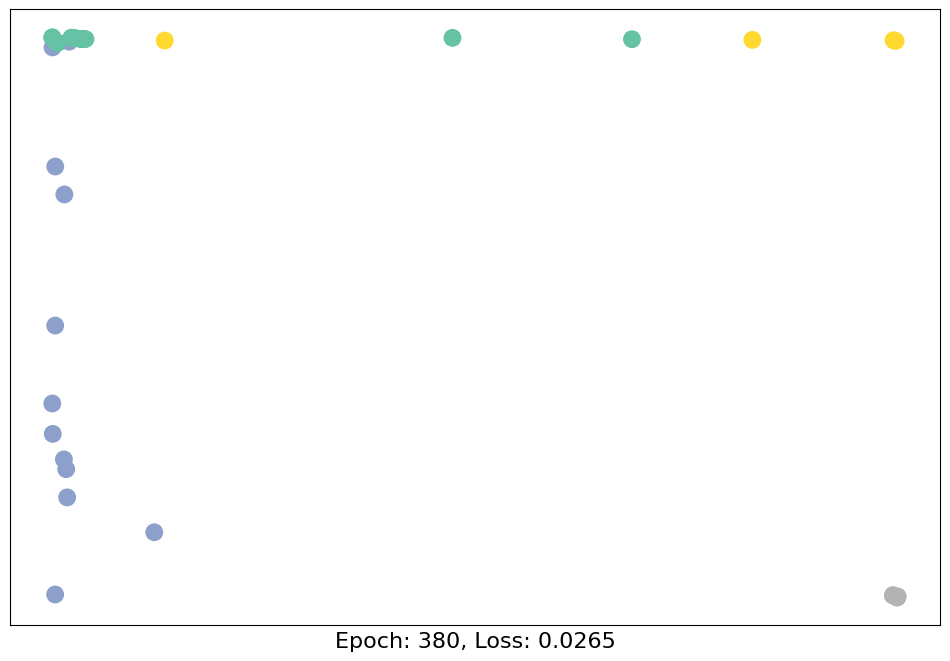

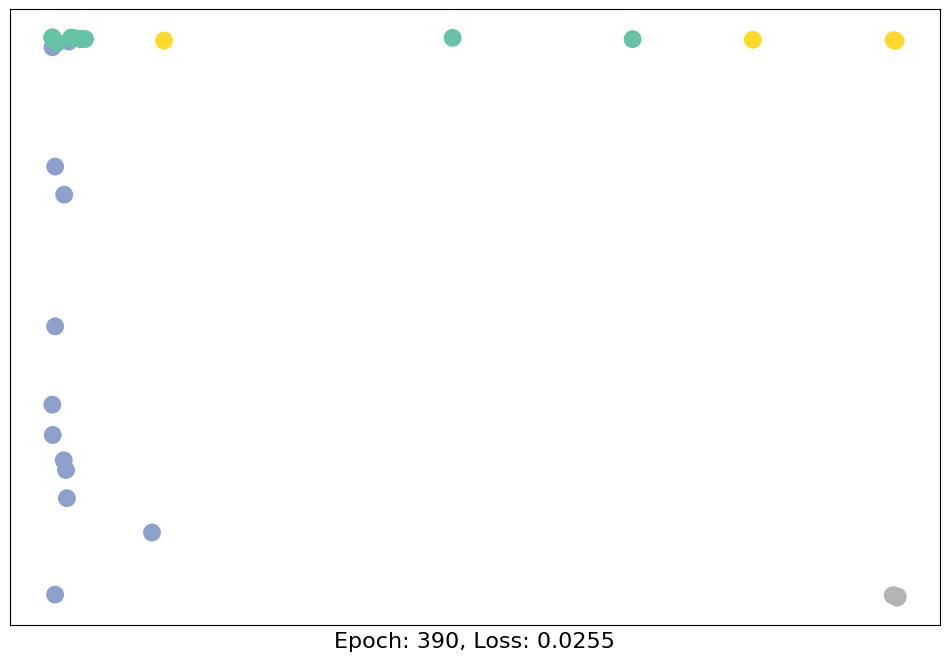

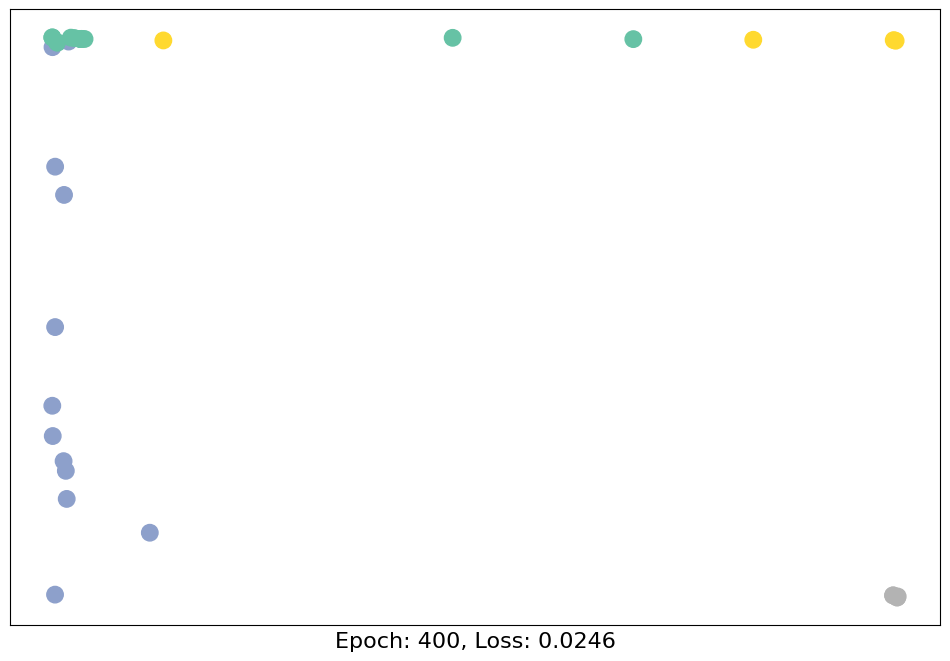

In [26]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

final_h = h # added by prodramp to visualize the final classification as TSNE

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h
     
import time

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
        ## Added by Me
        final_h = h



## A closer look into the trained model:

Although there is no `test_mask` (no test data), no performance statistics can be calculated.

In [27]:
model.eval()
out=model(data.x, data.edge_index)
out

(tensor([[-0.2345,  4.3591, -4.4310,  0.1436],
         [ 1.3456,  2.8111, -2.9429, -1.4126],
         [ 4.3243, -0.1533, -0.0824, -4.3379],
         [ 1.0921,  3.0593, -3.1815, -1.1629],
         [-3.9170,  0.8398,  0.6012,  5.0635],
         [-3.9515,  0.8397,  0.6091,  5.1036],
         [-3.9515,  0.8397,  0.6092,  5.1036],
         [ 1.9870,  2.1490, -2.2986, -2.0382],
         [ 4.3406, -0.2136, -0.0143, -4.3460],
         [ 4.3004, -0.2671,  0.0586, -4.2896],
         [-3.9173,  0.8395,  0.6016,  5.0639],
         [-0.1352,  3.4499, -3.3691,  0.1931],
         [ 0.5090,  3.5199, -3.5986, -0.5685],
         [ 3.3199,  0.8232, -1.0195, -3.3474],
         [ 4.2715, -0.3359,  0.1473, -4.2435],
         [ 4.2691, -0.3384,  0.1509, -4.2402],
         [-3.9464,  0.8293,  0.6204,  5.0996],
         [ 0.7460,  3.2917, -3.3801, -0.8026],
         [ 4.2662, -0.3436,  0.1577, -4.2359],
         [ 3.0462,  1.0192, -1.1912, -3.0647],
         [ 4.2517, -0.3553,  0.1749, -4.2169],
         [ 0.

In [28]:
model.state_dict()

OrderedDict([('conv1.bias', tensor([-0.0398,  0.0074,  0.0530,  0.0303])),
             ('conv1.lin.weight',
              tensor([[ 0.9893, -0.6488, -0.6693, -0.0615,  0.6027,  1.1585,  0.7938, -0.3729,
                       -0.6079, -1.0193,  0.8887, -0.1473,  0.3653, -0.5545, -0.8042, -0.4079,
                        1.0150,  0.2699, -0.9723,  0.0088, -0.6479,  0.1900, -0.3529, -0.5920,
                        0.4493,  0.3951, -0.5013, -0.0678, -1.1910, -1.0785, -1.0772, -0.2185,
                       -0.6120, -0.6529],
                      [-1.0868, -1.3011,  0.2456, -0.7954, -0.4431, -0.2655, -0.8488, -1.2820,
                        0.0860,  0.4040, -0.9798, -0.7531, -1.0100, -0.8316,  0.4007,  0.5778,
                       -0.5675, -1.1067,  0.9949, -1.2402,  0.7423, -1.2624,  0.5717,  0.9572,
                        1.2723,  1.3687,  0.7043,  1.0436,  0.9128,  1.2223,  0.2289,  1.3794,
                        0.5734,  1.0791],
                      [-0.3226,  0.6576,  0.890

In [29]:
print(model.type, "\n", model.share_memory, "\n", model.parameters)

<bound method Module.type of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)> 
 <bound method Module.share_memory of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)> 
 <bound method Module.parameters of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>


In [30]:
torch.save(model.state_dict(), 'KarateClub.h5')
torch.save(model, 'KarateClub_full.h5')
!ls -lah .

total 6040
drwxr-xr-x  13 massisenergy  staff   416B Sep 30 19:51 .
drwxr-xr-x@ 14 massisenergy  staff   448B Sep 30 19:51 ..
drwxr-xr-x@  2 massisenergy  staff    64B Sep 30 19:40 .ipynb_checkpoints
-rw-r--r--@  1 massisenergy  staff   191K Sep 18 20:29 GNN_MatrixTerminology.jpg
-rw-r--r--@  1 massisenergy  staff   1.1M Sep 30 19:51 GNN_explanations.ipynb
-rw-r--r--@  1 massisenergy  staff   234K Sep 19 01:33 GNNusage.jpg
-rw-r--r--@  1 massisenergy  staff   280K Sep 19 01:16 Graph_vsCNN_RNN.jpg
-rw-r--r--@  1 massisenergy  staff   3.4K Sep 30 19:54 KarateClub.h5
-rw-r--r--@  1 massisenergy  staff   9.0K Sep 30 19:54 KarateClub_full.h5
-rw-r--r--@  1 massisenergy  staff   515K Sep 27 12:37 MNIST_handwriting_GNN_PyTGeometric.ipynb
-rw-r--r--@  1 massisenergy  staff   223K Sep 19 01:30 MessagePassing_ForwardBackwardPass.jpg
-rw-r--r--@  1 massisenergy  staff   207K Sep 19 01:24 NodeOperation.jpg
-rw-r--r--@  1 massisenergy  staff   197K Sep 19 01:25 UnrolledNetworks.jpg


In [32]:
!pip install netron
# import netron
netron.start('KarateClub.h5')

NameError: name 'netron' is not defined

In [ ]:
netron.stop()